In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.keras.utils import timeseries_dataset_from_array

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

SetLowTFVerbose()

2022-09-10 20:15:20.694840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-10 20:15:20.704148: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
# Importing Files
def get_file_list (folder="Cleaned"):
    combined_path = ph.GetProcessedPath(folder)
    files = os.listdir(combined_path)
    files = [os.path.join(combined_path, file) for file in files]
    return files

def create_temp_files(file_list, rel_start=-400, rel_end=50):

    new_list = []

    temp_dir = ph.GetProcessedPath("Temp")
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)

        for i, file in enumerate (file_list):
            _df = pd.read_csv(file)
            _newfile = os.path.join(temp_dir, os.path.basename(file))
            new_list.append(_newfile)
            
            _app_end_ind = int (_df.loc[1, 'fParam'])
            _df = _df.loc[ (_app_end_ind+rel_start): (_app_end_ind+rel_end-1) , :]
            
            _df.to_csv(_newfile, index=False)
            print (f".. i = {i}/{len(file_list)}", end='\r')

    else:
        for file in file_list:
            _newfile = os.path.join(temp_dir, os.path.basename(file))
            new_list.append(_newfile)
    
    print ("Finished Processing Files")

    return new_list

def import_DFs(file_list):

    df_list = []

    for i, file in enumerate (file_list):
        _df = pd.read_csv(file)
        df_list.append(_df)

    return df_list


### Calculation Longitude and Latitude

In [3]:
appg_list = get_file_list("Approach.Good")
appb_list = get_file_list("Approach.Bad")

appg_DFs = import_DFs(appg_list)
appb_DFs = import_DFs(appb_list)

plt.style.use(['science', 'ieee'])

In [4]:
#appg_df['lat_rad'][284]

Text(-1.57011190224823, 0.611317087532753, 'Touchdown Point')

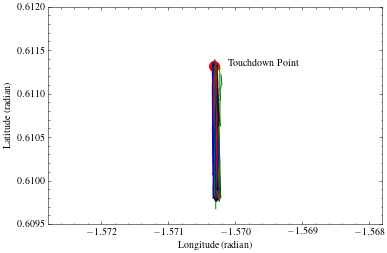

In [5]:
for i, appg_df in enumerate(appg_DFs):

    plt.plot(appg_df['lon_rad'], appg_df['lat_rad'], '-')
    plt.xlabel('Longitude (radian)')
    plt.ylabel('Latitude (radian)')
    plt.xlim((-1.5728, -1.5678))
    plt.ylim((0.6095, 0.6120))

    print ("i = {}".format(i), end="\r")

last_i = int (appg_df.shape[0] - 1)
plt.scatter(appg_df['lon_rad'][last_i], appg_df['lat_rad'][last_i], s=100, color="red")
plt.annotate("Touchdown Point", (appg_df['lon_rad'][last_i]+0.0002, appg_df['lat_rad'][last_i]))

Text(-1.57011190224823, 0.611317087532753, 'Touchdown Point')

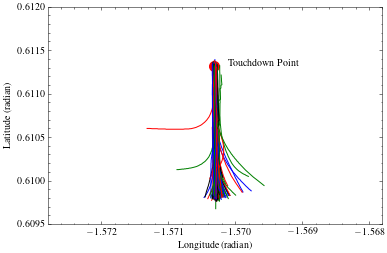

In [6]:
for i, appb_df in enumerate(appb_DFs):

    if appb_df['lat_rad'][0] > 0.6120:
        print ("i, -> {}; {}".format(i, appb_list[i]))

    plt.plot(appb_df['lon_rad'], appb_df['lat_rad'], '-')
    plt.xlabel('Longitude (radian)')
    plt.ylabel('Latitude (radian)')
    plt.xlim((-1.5728, -1.5678))
    plt.ylim((0.6095, 0.6120))

    print ("i = {}".format(i), end="\r")
plt.scatter(appg_df['lon_rad'][last_i], appg_df['lat_rad'][last_i], s=100, color="red")
plt.annotate("Touchdown Point", (appg_df['lon_rad'][last_i]+0.0002, appg_df['lat_rad'][last_i]))

### Empty Data 

In [7]:
app_list = get_file_list("Approach")
sel_list = get_file_list("Selected")

new_sel_list = []
for sel in sel_list:
    new_sel_list.append(os.path.basename(sel))

empty_list = []
count = 0
for app in app_list:
    if os.path.basename(app) not in new_sel_list:
        count += 1
        print ("{}, count: {}".format(os.path.basename(app), count))
        empty_list.append(os.path.basename(app))

In [8]:
inc = 0

In [9]:
combined_path = os.path.join (
            ph.GetProcessedPath("Sampled"), 
            "flight_25042.csv"# empty_list[inc]
        )

df = pd.read_csv(combined_path)
plt.scatter(df['time_s'], df['elv_l_rad'] * 180/math.pi, marker='x')

inc += 1
print ("inc: {}; \t filename: {}".format(inc, empty_list[inc]))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Sampled/flight_25042.csv'

In [ ]:
plt.scatter(df['time_s'], df['elv_l_rad'] * 180/math.pi, marker='x', alpha=0.4, linewidths=0.2)
plt.ylabel('Left Elevator Deflection (degree)')
plt.xlabel('time (s)')

NameError: name 'df' is not defined

### Making Graph of Flight Datas

In [10]:
from math import ceil


def PlotManyFlightDatas(df_list, column_list, unit_list, title='Features'):
    fig = plt.figure(constrained_layout=True)

    rows = int (ceil(len(column_list)/2) * 2)
    cols = 2

    gs = fig.add_gridspec(rows, cols)

    # Calculate max time
    maxTime = 0
    for df in df_list:
        if df.shape[0] > maxTime:
            maxTime = df.shape[0]

    i = 0
    for j in range(cols):
        for i in range(rows):
            if i*cols + j >= len(column_list):
                continue
            column = column_list[i*cols + j]
            unit = unit_list[i*cols + j]
            print (column)
            # Plot every labels for one flight

            ax = fig.add_subplot(gs[i, j])
            for df in df_list:
                ind = np.arange(15+df.shape[0], 15, -1)
                ax.plot (ind, df[column], alpha=0.2, color='black')
            ax.grid()

            ax.set_title(column)
            ax.set_xlabel("Time, seconds (s) Before Touchdown")
            ax.set_ylabel('\n'*j + unit)

            ax.invert_xaxis()

    fig.set_size_inches(18/4*cols*(7/8), 3*(3/4)*rows)
    fig.suptitle("{}\n".format(title))
    fig.savefig('figs/ch4_{}_plot.png'.format(title.lower()), dpi=500)
    fig.show()

In [11]:
Features    = [ 'hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 
                'gamma_error_rad', 'g_err_d_rad', 'tailwind_mps',]
FeatureUnits = ['m', 'm/s', 'radians', 'm/s', 'radians', 'rad/s', 'm/s']
    
Labels      = ['elv_l_rad', 'N1s_rpm']
LabelUnits  = ['radians', 'rpm']

train_list = get_file_list("Train")
train_DFs = import_DFs(train_list)

hralt_m
theta_rad
gamma_error_rad
tailwind_mps
hdot_1_mps
cas_mps
g_err_d_rad


/tmp/ipykernel_11590/112461368.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


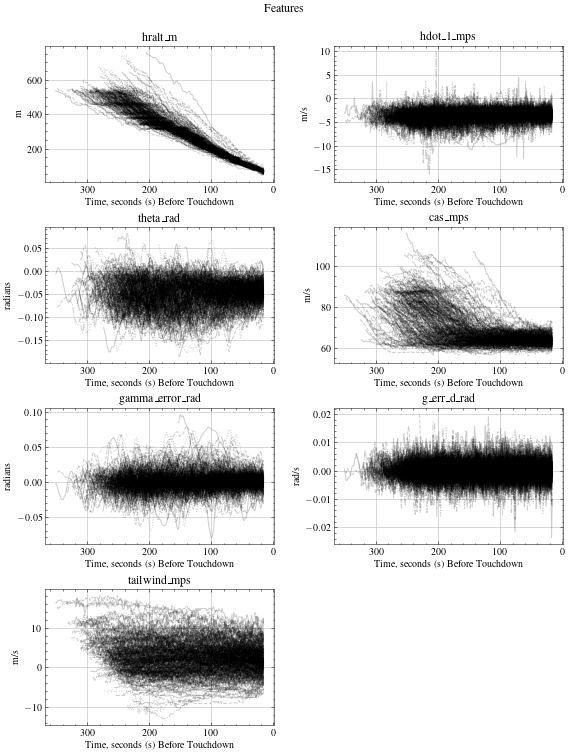

In [12]:
PlotManyFlightDatas(train_DFs, Features, FeatureUnits, 'Features')

elv_l_rad
N1s_rpm


/tmp/ipykernel_11590/112461368.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


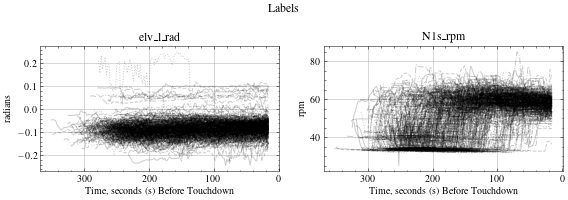

In [13]:
PlotManyFlightDatas(train_DFs, Labels, LabelUnits, 'Labels')

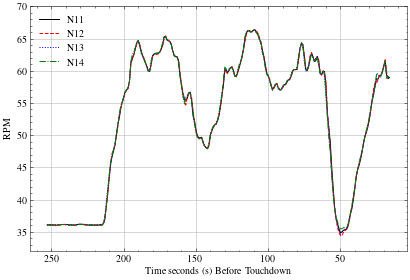

In [14]:
filename = train_list[4]
df = pd.read_csv(filename)
ind = np.arange(15+df.shape[0], 15, -1)

plt.figure(1, (18/4*(3/2), 3*(3/2)))

plt.plot(ind, df['n11_rpm'])
plt.plot(ind, df['n12_rpm'])
plt.plot(ind, df['n13_rpm'])
plt.plot(ind, df['n14_rpm'])

plt.legend(['N11', 'N12', 'N13', 'N14'])

plt.ylim((32, 70))
plt.ylabel('RPM')
plt.xlabel('Time seconds (s) Before Touchdown')

plt.grid()
plt.gca().invert_xaxis() 

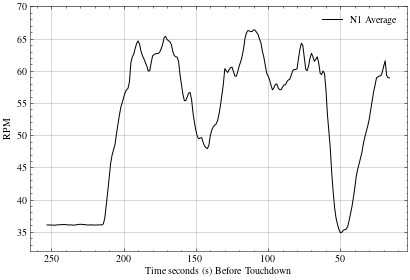

In [15]:
plt.figure(1, (18/4*(3/2), 3*(3/2)))

plt.plot(ind, df['N1s_rpm'])

plt.legend(['N1 Average'])

plt.ylim((32, 70))
plt.ylabel('RPM')
plt.xlabel('Time seconds (s) Before Touchdown')

plt.grid()
plt.gca().invert_xaxis() 

In [16]:
filename

'/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Train/flight_20068.csv'

78


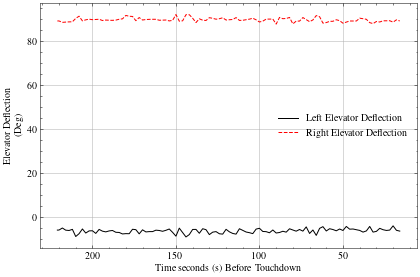

In [17]:
i = int(np.random.random()*(len(train_list)-1))
filename = train_list[i]
print (i)
df = pd.read_csv(filename)
ind = np.arange(15+df.shape[0], 15, -1)

plt.figure(1, (18/4*(3/2), 3*(3/2)))

plt.plot(ind, df['elv_l_rad'] * 180/math.pi)
plt.plot(ind, df['elv_r_rad'] * 180/math.pi)

plt.legend(['Left Elevator Deflection', 'Right Elevator Deflection'])

#plt.ylim((32, 70))
plt.ylabel('Elevator Deflection \n (Deg)')
plt.xlabel('Time seconds (s) Before Touchdown')

plt.grid()
plt.gca().invert_xaxis() 

11


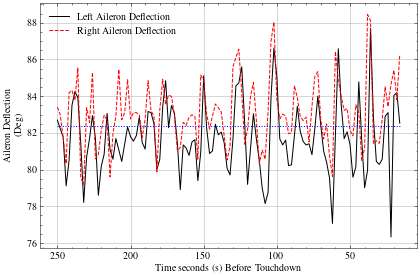

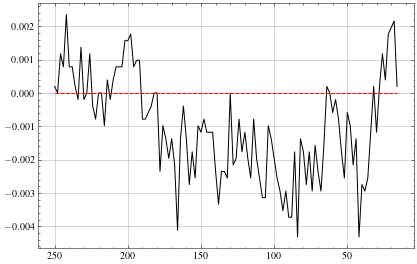

In [18]:
i = int(np.random.random()*(len(train_list)-1))
filename = train_list[i]
print (i)
df = pd.read_csv(filename)
ind = np.arange(15+df.shape[0], 15, -1)
line = np.ones((df.shape[0],)) * 82.38859463309642

plt.figure(1, (18/4*(3/2), 3*(3/2)))

plt.plot(ind, df['ail_l_rad'] * 180/math.pi) # * 180/math.pi
plt.plot(ind, df['ail_r_rad'] * 180/math.pi)
plt.plot(ind, line)

plt.legend(['Left Aileron Deflection', 'Right Aileron Deflection'])

#plt.ylim((32, 70))
plt.ylabel('Aileron Deflection \n (Deg)')
plt.xlabel('Time seconds (s) Before Touchdown')

plt.grid()
plt.gca().invert_xaxis()
plt.show()

plt.figure(1, (18/4*(3/2), 3*(3/2)))
plt.plot(ind, df['loc_dev_ddm'])
plt.plot(ind, ind*0)
plt.grid()
plt.gca().invert_xaxis()
plt.show()

In [19]:
avg_sum = 0
for i, train in enumerate (train_list):
    df = pd.read_csv(train)
    avg_sum += 0.5*(df['ail_l_rad'].mean() + df['ail_r_rad'].mean()) * 180/math.pi

avg_sum = avg_sum/len(train_list)
print (avg_sum)


82.38859463309642


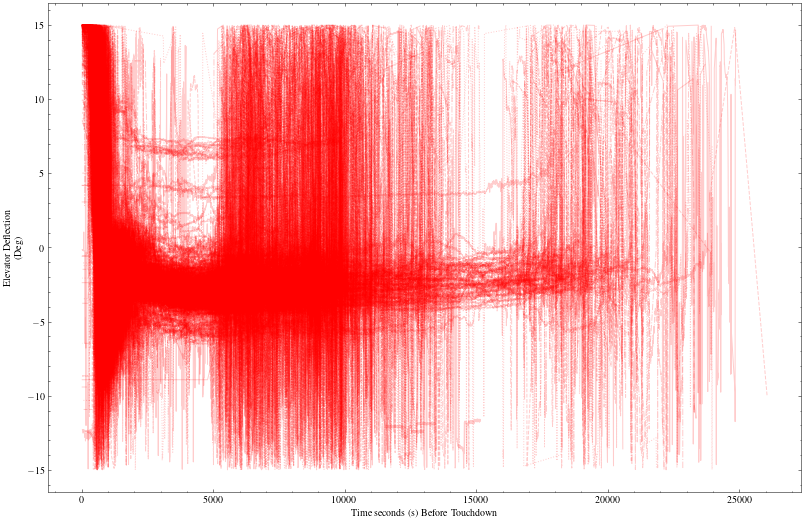

In [24]:

cleaned_list = get_file_list("Cleaned")

for filename in cleaned_list:
    df = pd.read_csv(filename)
    ind = np.arange(15+df.shape[0], 15, -1)

    plt.figure(1, (18/4*(3), 3*(3)))

    plt.plot(ind, df['elv_l_rad'] * 180/math.pi, color='red', alpha=0.2)
    # plt.plot(ind, df['elv_r_rad'] * 180/math.pi)

    # plt.legend(['Left Elevator Deflection'])#, 'Right Elevator Deflection'])

    #plt.ylim((32, 70))
    plt.ylabel('Elevator Deflection \n (Deg)')
    plt.xlabel('Time seconds (s) Before Touchdown')

    plt.grid()
    plt.gca().invert_xaxis() 
plt.show()

448


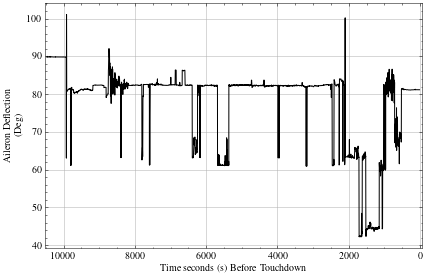

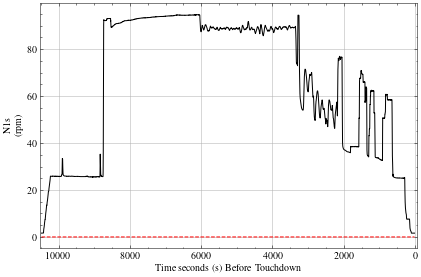

range: 27.720600564452173
Ail_0: 89.86382330347179
Ail_typ: 82.45802026380325
Ail_up: 18.60656009833926
Ail_down: 40.28181848755513
Max N1s: 94.75


In [65]:
i = int(np.random.random()*(len(cleaned_list)-1))
filename = cleaned_list[i]
print (i)
df = pd.read_csv(filename)
ind = np.arange(15+df.shape[0], 15, -1)
line = np.ones((df.shape[0],)) * 82.38859463309642

plt.figure(1, (18/4*(3/2), 3*(3/2)))

plt.plot(ind, 0.5*(df['ail_l_rad']+df['ail_r_rad']) * 180/math.pi) # * 180/math.pi


#plt.ylim((32, 70))
plt.ylabel('Aileron Deflection \n (Deg)')
plt.xlabel('Time seconds (s) Before Touchdown')
plt.xlim((-50, df.shape[0]+50))
plt.grid()
plt.gca().invert_xaxis()
plt.show()

plt.figure(1, (18/4*(3/2), 3*(3/2)))
plt.plot(ind, df['N1s_rpm'])
plt.plot(ind, ind*0)
plt.ylabel('N1s \n (rpm)')
plt.xlabel('Time seconds (s) Before Touchdown')
plt.xlim((-50, df.shape[0]+50))
plt.grid()
plt.gca().invert_xaxis()
plt.show()

df['ail_lr_rad'] = 0.5*(df['ail_l_rad']+df['ail_r_rad'])

ail_0 = 0.5*(df['ail_l_rad'][0]+df['ail_r_rad'][0])* 180/math.pi
ail_typ = 0.5*(df['ail_l_rad'][int(df.shape[0]/2)]+df['ail_r_rad'][int(df.shape[0]/2)])* 180/math.pi
ail_up = df['ail_lr_rad'].max() * 180/math.pi - ail_typ
ail_down = ail_typ - df['ail_lr_rad'].min() * 180/math.pi

print ("range: {}".format((df['elv_l_rad'].max() - df['elv_l_rad'].min())* 180/math.pi))
print ("Ail_0: {}".format(ail_0))
print ("Ail_typ: {}".format(ail_typ))
print ("Ail_up: {}".format(ail_up))
print ("Ail_down: {}".format(ail_down))
print ("Max N1s: {}".format(df['N1s_rpm'].max()))

In [3]:
#old_file_list = get_file_list()

#file_list = create_temp_files(old_file_list)

#df_list = import_DFs(file_list)

#len(df_list)

Finished Processing Files


550

In [4]:
# Plot column

def plot_column(df_list, column, alpha=.02):
    
    _x = [i for i in range(df_list[0].shape[0])]

    for i, _df in enumerate (df_list):        
        # _app_end_ind = int (_df.loc[1, 'fParam'])
        _y = _df.loc[:, column]
        
        plt.plot(_x, _y, alpha=alpha, color='red')
        print (f".. i = {i}/{len(file_list)}", end='\r')
    
    print ("Finished                  ")
    plt.show()

Finished                  


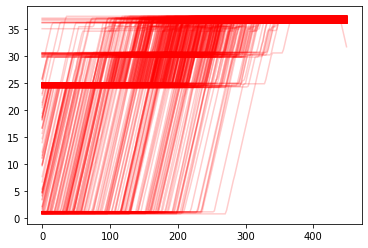

Finished                  


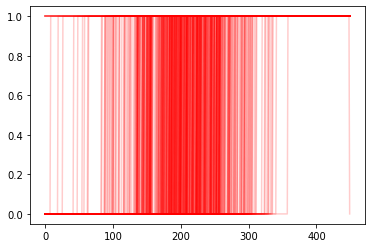

In [16]:
plot_column(df_list, "flap_te_pos", alpha=.2)
plot_column(df_list, "flap_6_bool", alpha=.2)

In [6]:
# filter usable df
if False:
    passed_dfs = []
    passed_dfs_i = []
    total_len = df_list[0].shape[0]
    psi_thres = .05
    _3deg_mult = 1000 * math.tan(3*math.pi/180)

    for i, df in enumerate(df_list):
        
        if abs(df.loc[0, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[30, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[total_len-300, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[total_len-250, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[total_len-200, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[total_len-100, 'psi_rad']) > psi_thres:
            continue
        if abs(df.loc[total_len-50, 'psi_rad']) > psi_thres:
            continue

        if abs(df.loc[150, 'hralt_m']) > 600:
            continue
        if abs(df.loc[100, 'hralt_m']) > 600:
            continue
        if abs(df.loc[50, 'hralt_m']) > 600:
            continue

        if abs(df.loc[150, 'dist_to_land']*_3deg_mult - df.loc[150, 'hralt_m']) > 20:
            continue
        if abs(df.loc[100, 'dist_to_land']*_3deg_mult - df.loc[100, 'hralt_m']) > 20:
            continue

        passed_dfs.append(df)
        passed_dfs_i.append(i)

    len (passed_dfs)

4

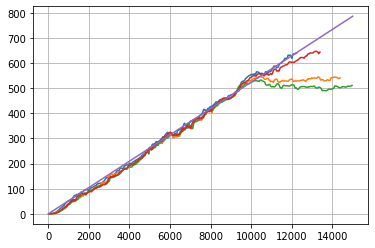

In [7]:
_x = [i for i in range(df_list[0].shape[0])]
_x_dist = [i for i in range(15000)]
_y_3deg = [math.tan(3*math.pi/180) * i for i in range(15000)]

for df in passed_dfs:
    # plt.plot(_x, df.loc[:, 'hralt_m'])
    plt.plot(df.loc[:, 'dist_to_land']*1000, df.loc[:, 'hralt_m'])

plt.grid(True)
plt.plot(_x_dist, _y_3deg)
plt.show()

In [8]:
for i in passed_dfs_i:
    print (file_list[i])


/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_23366.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_31077.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_10603.csv
/home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Processed/Temp/flight_23067.csv


In [9]:
column = "pla_1_rad"

_max = -999
_min = 999

for i, file in enumerate(old_file_list):
    _df = pd.read_csv(file)
    _col = _df.loc[:, column]

    if _col.max() > _max:
        _max = _col.max()
    if _col.min() < _min:
        _min = _col.min()

print (f"min: {_min}")
print (f"max: {_max}")

min: -0.0444851652590954
max: 1.67509575405121


In [10]:
_min * 180 / math.pi

-2.5488122202881596

In [11]:
_max * 180 / math.pi

95.97591698741849

97.859375

35.01619097009047